In [5]:
#download and unzip dataset
#dataset has been augmented with horizontal,vertical flips and brightness variations
!curl -L https://app.roboflow.ai/ds/3fZYcO8lo1?key=qyRmcj1Q3Q > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   889  100   889    0     0    386      0  0:00:02  0:00:02 --:--:--   385
100  210M  100  210M    0     0  29.0M      0  0:00:07  0:00:07 --:--:-- 54.1M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     


In [0]:
#include dependencies
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [0]:
#build model
def buildModel(shape,nontrainable=0) :
  base_model = tf.keras.applications.DenseNet121(input_shape=(shape,shape,3),include_top=False)
  if nontrainable:
    for i in range(nontrainable) :
      base_model.layers[i].trainable = False

  x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  x = tf.keras.layers.Dense(4,activation='softmax')(x)
  model = tf.keras.Model(inputs=base_model.input,outputs=x)
  return model

In [0]:
def predict(path,shape):
  labels = ['healthy','multiple_diseases','rust','scab']
  img = load_img(path,target_size=(shape,shape))
  plt.imshow(img)
  img = img_to_array(img).astype('float')/255
  img = np.expand_dims(img,axis=0)
  return labels[np.argmax(model.predict(img))]

In [4]:
#create model
model = buildModel(512)
len(model.layers)

29089792/29084464 [==============================] - 1s 0us/step


429

In [0]:
#pretrained model
model.load_weights('drive/My Drive/Apple_disease/image_generator_4.hdf5')

In [6]:
#create generators
train_datagen = ImageDataGenerator(rescale= 1./255)
train_generator = train_datagen.flow_from_directory(r"train/",target_size=(512,512),batch_size=16,seed=42)
valid_generator = train_datagen.flow_from_directory(r"valid/",target_size=(512,512),batch_size=64,seed=42)

Found 3079 images belonging to 4 classes.
Found 273 images belonging to 4 classes.


In [0]:
#declare number of steps
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = valid_generator.n//valid_generator.batch_size

In [0]:
#determine model parameters
save_path = 'drive/My Drive/Apple_disease/image_generator_4.hdf5'
callback1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=1,min_delta=0.01, factor=0.1)
callback2 = tf.keras.callbacks.ModelCheckpoint(save_path,save_best_only=True)
optimizer = tf.keras.optimizers.SGD(0.1,momentum=0.9,nesterov=True,clipnorm=1.)
callbacks = [callback1,callback2]

In [0]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
model.fit(train_generator,steps_per_epoch=step_size_train,validation_data=valid_generator,validation_steps=step_size_valid,epochs=20, callbacks=callbacks)

Epoch 1/20
129/192 [===================>..........] - ETA: 2:40 - loss: 0.3364 - accuracy: 0.9066

In [19]:
model.evaluate(valid_generator)

5/5 [==============================] - 134s 27s/step - loss: 0.2712 - accuracy: 0.9524


[0.2712413966655731, 0.9523809552192688]

'multiple_diseases'

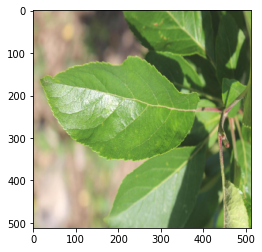

In [22]:
#make prediction for a random image
predict('/content/train/multiple_diseases/Train_104_jpg.rf.2f0fec88c76217fe81615e2fc92ec7cb.jpg',512)